# Final project: Compressed sensing decoder

#### Telecom guys: Avdotin Evgeny, Smeshko Anastasiia, Daria Ustinova


# 1. Problem statement

We consider a wireless network that is composed of  $K_{a}$ active users. Every active user wishes to transmit $B$ bits of information to the base station. The number of resources (channel) uses in this process is $N$ and they are split into $V$ slots. Denote the set of $B$-bit messages which corresponds to the set of active users as $\mathbf{W}={\{ w_{1},...,w_{K_{a}}\}}$. Users encode the message index $w_{i}$ into a codeword of length $n$, which after binary phase-shift keying (BPSK) modulation belongs to the alphabet $\{1,-1\}$ (${x}_{w_{i}} \in \{1,-1\}$).

Denote the $\mathcal{N}_{j}$ set of users, who transmit to the $j-$th slot, $j=1,\ldots,V$. Then in each slot we'll receive:
$$
    \mathbf{y}_{j}=\sum_{i\in\mathcal{N}_{j}}{\mathbf{x}_{w_{i}}}+\mathbf{z}_{j},
$$
where $\mathbf{x}_{w_{j}}$ is BPSK modulated codeword transmitted by the $i$-th user and $\mathbf{z}_{j} \sim \mathcal{N}(\mathbf{0}, \sigma^2)$ is an additive Gaussian noise (AWGN).

Thus, in slot we receive the sum of $|\mathcal{N}_{j}|=T$ messages and want to determine each $x_{w_{i}}$. We can represent this sum as a multiplication of matrix $A$ and sparse vector $b_{j}$:

$$
\mathbf{y}_{j} = A b_{j} + \mathbf{z}_{j},
$$
where we consider matrix $A_{n*m}$ - matrix with all possible modulated codewords as columns, $b_{j}$ - activity vector with exactly $T$ ones (on transmitted codewords places) and other zeros.

Consequently, our decoding task can be reduced to searching the right active vector (among all vectors with $T$ ones):

$$
\hat{b} = argmin_{b_j}||A b_j - \mathbf{y}_{j} ||
$$

- If we consider $||.||_{1}$, this problem could be interpreted as compressed sensing problem

- If we consider $||.||_{2}$, this is non-negative least squares problem (NNLS), or bounded-variable least squares (BVLS), because we have rectrictions for vector $b_j$.

# 2. Sensing matrix construction

In [ ]:
import numpy as np
import random
import scipy
from scipy.optimize import nnls
import math
from heapq import nlargest

In [ ]:
# specify some parameters
k = 3 #number of information bits
n = 7 #length of codeword
T = 2 #number of users in slot

SNR_array = np.arange(-8,5)


#generate information symbols - all possible vectors with length k on alphabet 2**K

def get_info_vectors(q,k):
    temp = np.array([np.arange(q**k)]) # numbers from 0 to q**k-1
    info = temp%q
    temp = np.floor(temp/q)
    for i in range(1,k):
        info = np.concatenate((temp%q,info),axis=0)
        temp = np.floor(temp/q)
    return info

C = get_info_vectors(2**k,k).T

#Kautz - Singleton encoding (this only for q-ary codes) 

C_KS = np.zeros(((2**k)**k,k*2**k))
vector = np.zeros((1,2**k))
vector[0,0] = 1
for i in np.arange(C.shape[0]):
    for j in np.arange(C.shape[1]):
        C_KS[i,(2**k)*j:(2**k)*(j+1)]=np.roll(vector,int(C[i,j]))
        
        
C_KS = 1- 2*C_KS

In [ ]:
!pip install pyldpc

     |████████████████████████████████| 1.1MB 9.3MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=82eb7d32e27d11599d2a583d213129605002f9b9679de3595077ac3fd8819807
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc


We construct out codebook with the help of Low-density parity-check code (LDPC)

In [ ]:
from pyldpc import make_ldpc, encode, decode, get_message
n = 35
d_v = 6
d_c = 7
snr = 20
H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
k = G.shape[1]
print(k)

10


In [ ]:
A = encode(G,get_info_vectors(2,10),1000) #sensing matrix

## 3. Problem solution 
### 3.1 NNLS: apply non-negative least squares solver from scipy.optimize
This is the method that authors used for solving the problem (https://avinashvem.github.io/unsourcedma.pdf)

In [ ]:
num_tests = 2000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_T = np.zeros((1,len(SNR_array)))
#Pr_error_perUser = np.zeros((1,len(SNR_array)))
Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        
        cdws = sorted(cdws)

        set_idxs = set([cdws[i][0] for i in range(T)])

        #print(set(perm))
        #print(set_idxs)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_T[0,i]=error/test
print(Pr_error_T)

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

+ Firstly, we decided to improve authors' solution by adding N_list - search not T maximal, but some number (e.g. N_list = 10). Then we consider all possible combinations $C_{N_{list}}^{T}$ and find the minimum distanse in terms of $||\cdot||_2$

In [ ]:
import itertools

In [ ]:
num_tests = 2000
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error = np.zeros((1,len(SNR_array)))
T = 2

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error[0,i]=error/test

KeyboardInterrupt: ignored

In [ ]:
Pr_error =[0.90775, 0.83775, 0.72175, 0.54   , 0.2855 , 0.1105 , 0.046  ,0.0195 , 0.0175 , 0.014  , 0.013  , 0.0095 , 0.0065 ]

In [ ]:
Pr_error_T

array([[0.924  , 0.86275, 0.76475, 0.58925, 0.3775 , 0.167  , 0.05725,
        0.0235 , 0.017  , 0.009  , 0.008  , 0.01   , 0.009  ]])

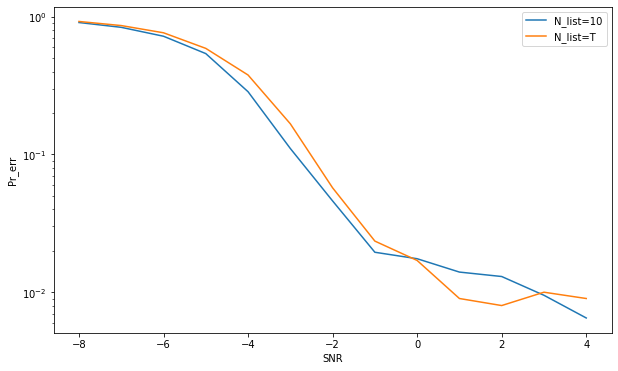

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="N_list=10")
ax.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="N_list=T")

ax.set_xlabel("SNR")
ax.set_ylabel("Pr_err")

ax.legend()
plt.show()

As we can see, increasing of N_list will lead to increasing in accuracy (and complexity)

### 3.2 Least squares with bounds [0,1] and initial guess  (consider it equiprobable)

In [ ]:
from scipy.optimize import least_squares

In [ ]:
def leastsq(x):    
    return A@x - y

In [ ]:
# initial guess

x0=np.ones(1024)/2

In [ ]:
num_tests = 1000
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_ls = np.zeros((1,len(SNR_array)))

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_lss = least_squares(leastsq,x0, bounds=(0,1))
        
        cdws = nlargest(N_list, enumerate(b_lss.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_ls[0,i]=error/test

KeyboardInterrupt: ignored

In [ ]:
Pr_error_ls = [0.9015, 0.8355, 0.7,    0.52,   0.2425, 0.078,  0.0255, 0.0155, 0.0085, 0.009,  0.005,  0.005,  0.003 ]

In [ ]:
Pr_error_ls_T = [0.902,  0.812,  0.6845, 0.544,  0.394,  0.246,  0.1475, 0.0765, 0.044,  0.021,  0.015,  0.0095, 0.0085]

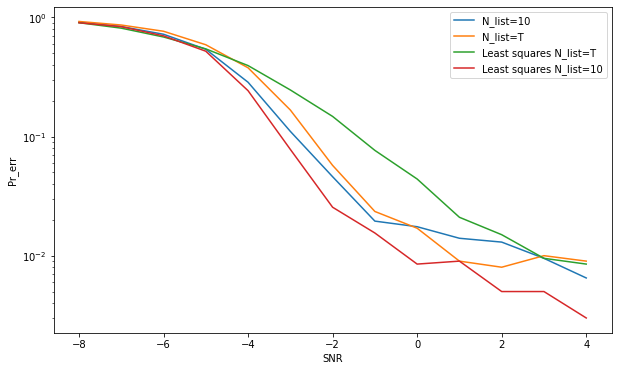

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="N_list=10")
ax.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="N_list=T")

ax.semilogy(SNR_array,Pr_error_ls_T,label="Least squares N_list=T")
ax.semilogy(SNR_array,Pr_error_ls,label="Least squares N_list=10")

ax.set_xlabel("SNR")
ax.set_ylabel("Pr_err")

ax.legend()
plt.show()

### 3.3 BVLS


In [ ]:
from scipy.optimize import lsq_linear

In [ ]:
num_tests = 2000
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_bv = np.zeros((1,len(SNR_array)))

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #BVLS
        ans = lsq_linear(A, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_bv[0,i]=error/test

In [ ]:
Pr_error_bv = [0.9065 , 0.83575, 0.72225, 0.508  , 0.25525, 0.088  , 0.023  , 0.01475, 0.005  , 0.006  , 0.0075 , 0.009  , 0.0035 ]

In [ ]:
num_tests = 2000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_bv_T = np.zeros((1,len(SNR_array)))
#Pr_error_perUser = np.zeros((1,len(SNR_array)))
Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        ans = lsq_linear(A, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)

        set_idxs = set([cdws[i][0] for i in range(T)])

        #print(set(perm))
        #print(set_idxs)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_bv_T[0,i]=error/test
print(Pr_error_bv_T)

[[0.9005  0.83025 0.70225 0.5455  0.37625 0.2415  0.144   0.08475 0.0435
  0.025   0.014   0.011   0.009  ]]


In [ ]:
Pr_error_bv_T = [0.9005,  0.83025, 0.70225, 0.5455,  0.37625, 0.2415,  0.144,   0.08475, 0.0435,
  0.025,   0.014,   0.011,   0.009  ]

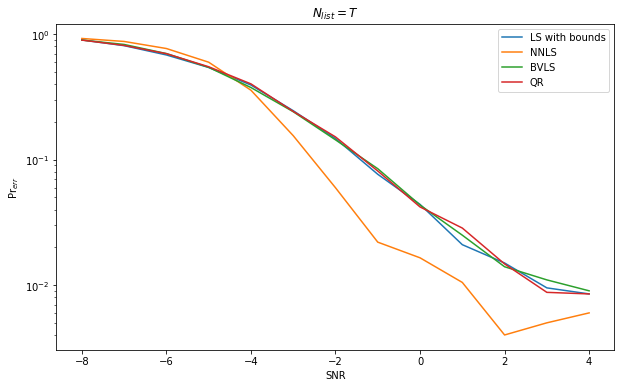

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array, Pr_error_ls_T, label="LS with bounds")
ax.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="NNLS")
ax.semilogy(SNR_array,np.reshape(Pr_error_bv_T, (1,np.product(Pr_error_bv_T.shape)))[0],label="BVLS")
ax.semilogy(SNR_array, np.reshape(Pr_error_T_qr, (1,np.product(Pr_error_T_qr.shape)))[0],label="QR")

ax.set_xlabel("SNR")
ax.set_ylabel("$\Pr_{err}$")
ax.set_title("$N_{list}=T$")

ax.legend()
plt.show()

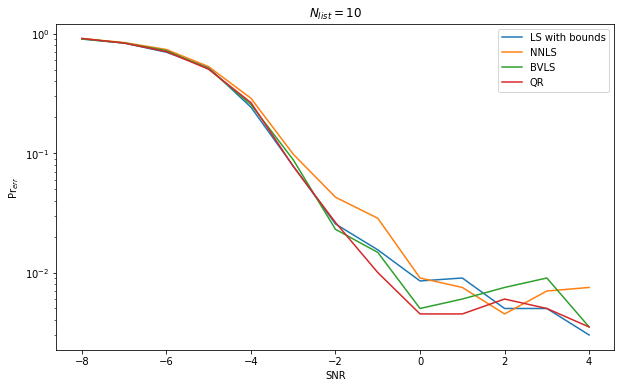

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array, Pr_error_ls, label="LS with bounds")
ax.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="NNLS")
ax.semilogy(SNR_array,np.reshape(Pr_error_bv, (1,np.product(Pr_error_bv.shape)))[0],label="BVLS")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="QR")

ax.set_xlabel("SNR")
ax.set_ylabel("$\Pr_{err}$")
ax.set_title("$N_{list}=10$")

ax.legend()
plt.show()

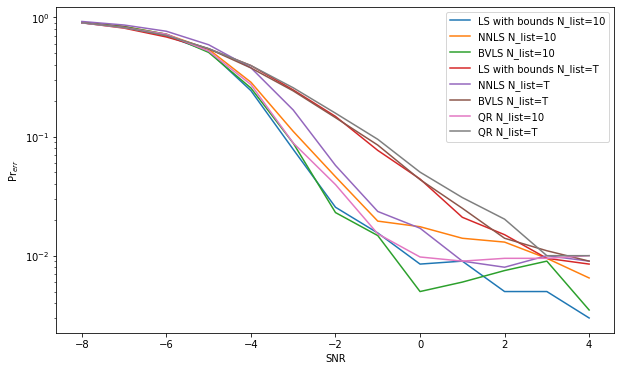

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array, Pr_error_ls, label="LS with bounds N_list=10")
ax.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="NNLS N_list=10")
ax.semilogy(SNR_array,Pr_error_bv,label="BVLS N_list=10")
ax.semilogy(SNR_array, Pr_error_ls_T, label="LS with bounds N_list=T")
ax.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="NNLS N_list=T")
ax.semilogy(SNR_array,Pr_error_bv_T,label="BVLS N_list=T")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="QR N_list=10")
ax.semilogy(SNR_array, np.reshape(Pr_error_T_qr, (1,np.product(Pr_error_T_qr.shape)))[0],label="QR N_list=T")

ax.set_xlabel("SNR")
ax.set_ylabel("$\Pr_{err}$")

ax.legend()
plt.show()

As we can see, BVLS gives better results

### 3.4 Compressed sensing and DCT

In [ ]:
# Here we use just a part of our codebook

In [ ]:
from sklearn import linear_model
from scipy.fftpack import dct, idct
from scipy.sparse import coo_matrix
from matplotlib.pyplot import plot, show, figure, title
import numpy as np

In [ ]:
num_part = 100
T = 2
n = 50
code = np.random.randint(2, size=(num_part, n))
num_channel = T*num_part
rand_senders = np.random.choice(np.arange(num_part), size=(num_channel,T))
encoded = 1 - 2*code
after_transmission_code = np.zeros((num_channel, n))
for i in range(num_channel):
    after_transmission_code[i] = encoded[rand_senders[i]].sum(0) +  np.random.normal(scale=1., size=n)

In [ ]:
D = dct(code.T) # Here, we model using the DCT
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
success = 0
for i in range(num_channel):
    lasso.fit(D, after_transmission_code[i])
    # Creates the fourier transform that will most minimize l1 norm 
    recons = idct(lasso.coef_, axis=0)
    num_code = np.argsort(np.abs(recons))[-T-1:]
    if sum([elem in rand_senders[i] for elem in num_code]) == T:
        success += 1
    # else:
    #     print(i, rand_senders[i], num_code)

In [ ]:
success

128

In [ ]:
num_tests = 1000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_cs_T = np.zeros((1,len(SNR_array)))
#Pr_error_perUser = np.zeros((1,len(SNR_array)))
A = encode(G,get_info_vectors(2,10),1000) #sensing matrix
Mp = 2**k

In [ ]:
choice = sorted(np.random.choice(np.arange(1024), replace=False, size=80))
D = (A[:, choice] - 1) / -2 + 0
D = dct(D)

In [ ]:
A_new = A[:, choice]

In [ ]:
# D = dct(D) # Here, we model using the DCT
Pr_error_cs = np.zeros((1,len(SNR_array)))
Pr_error_l_bvls = np.zeros((1,len(SNR_array)))
Pr_error_l_nnls = np.zeros((1,len(SNR_array)))
Pr_error_l_qr = np.zeros((1,len(SNR_array)))
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = 10
Pr_error_cs = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    error_bvls = 0
    error_nnls = 0
    error_qr = 0

    #error_perUser = 0
    test = 0
    size_ = 80
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A_new@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A_new.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error = error + (T-len(set_idxs&set(perm)))/T



        ans = lsq_linear(A_new, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_bvls = error_bvls + (T-len(set_idxs&set(perm)))/T     




        ans = np.array([nnls(A_new,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_nnls = error_nnls + (T-len(set_idxs&set(perm)))/T



        Q, R = np.linalg.qr(A_new, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_qr = error_qr + (T-len(set_idxs&set(perm)))/T
        
        test = test+1
    Pr_error_cs[0,i]=error/test
    Pr_error_l_bvls[0,i]=error_bvls/test
    Pr_error_l_nnls[0,i]=error_nnls/test
    Pr_error_l_qr[0,i]=error_qr/test

In [ ]:
Pr_error_cs, Pr_error_l_bvls, Pr_error_l_nnls

array([[0.82 , 0.725, 0.525, 0.42 , 0.325, 0.19 , 0.105, 0.075, 0.06 ,
        0.04 , 0.025, 0.015, 0.02 ]])

In [ ]:
Pr_error_cs, Pr_error_l_bvls, Pr_error_l_nnls, Pr_error_l_qr

(array([[0.8  , 0.66 , 0.495, 0.345, 0.21 , 0.09 , 0.05 , 0.055, 0.005,
         0.01 , 0.005, 0.015, 0.   ]]),
 array([[0.77 , 0.64 , 0.505, 0.535, 0.445, 0.46 , 0.355, 0.445, 0.475,
         0.365, 0.335, 0.435, 0.355]]),
 array([[0.8  , 0.7  , 0.57 , 0.53 , 0.38 , 0.255, 0.2  , 0.15 , 0.04 ,
         0.015, 0.01 , 0.005, 0.   ]]),
 array([[0.725, 0.585, 0.4  , 0.165, 0.065, 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   ]]))

In [ ]:
choice = sorted(np.random.choice(np.arange(1024), replace=False, size=60))
D = (A[:, choice] - 1) / -2 + 0
D = dct(D)
A_new = A[:, choice]

In [ ]:
# D = dct(D) # Here, we model using the DCT
T = 4
Pr_error_cs = np.zeros((1,len(SNR_array)))
Pr_error_l_bvls = np.zeros((1,len(SNR_array)))
Pr_error_l_nnls = np.zeros((1,len(SNR_array)))
Pr_error_l_qr = np.zeros((1,len(SNR_array)))
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = 10
Pr_error_cs = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    error_bvls = 0
    error_nnls = 0
    error_qr = 0

    #error_perUser = 0
    test = 0
    size_ = 60
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A_new@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A_new.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error = error + (T-len(set_idxs&set(perm)))/T



        ans = lsq_linear(A_new, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_bvls = error_bvls + (T-len(set_idxs&set(perm)))/T     




        ans = np.array([nnls(A_new,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_nnls = error_nnls + (T-len(set_idxs&set(perm)))/T



        Q, R = np.linalg.qr(A_new, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_qr = error_qr + (T-len(set_idxs&set(perm)))/T
        
        test = test+1
    Pr_error_cs[0,i]=error/test
    Pr_error_l_bvls[0,i]=error_bvls/test
    Pr_error_l_nnls[0,i]=error_nnls/test
    Pr_error_l_qr[0,i]=error_qr/test

In [ ]:
Pr_error_cs, Pr_error_l_bvls, Pr_error_l_nnls, Pr_error_l_qr

(array([[0.7075, 0.7325, 0.5725, 0.5475, 0.475 , 0.4125, 0.4025, 0.405 ,
         0.395 , 0.3825, 0.355 , 0.3725, 0.3875]]),
 array([[0.645 , 0.6475, 0.575 , 0.5025, 0.4825, 0.47  , 0.5025, 0.465 ,
         0.445 , 0.455 , 0.4075, 0.44  , 0.4425]]),
 array([[0.79  , 0.77  , 0.7125, 0.6475, 0.58  , 0.5725, 0.4925, 0.475 ,
         0.4275, 0.43  , 0.425 , 0.4175, 0.405 ]]),
 array([[0.6075, 0.6125, 0.525 , 0.4575, 0.425 , 0.41  , 0.38  , 0.3775,
         0.355 , 0.375 , 0.3675, 0.3475, 0.3775]]))

In [ ]:
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = T
Pr_error_cs_T = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    size_ = 100
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A[:, choice]@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_cs_T[0,i]=error/test
    print(Pr_error_cs_T)

In [ ]:
Pr_error_cs_T

array([[0.93 , 0.86 , 0.87 , 0.71 , 0.67 , 0.455, 0.405, 0.33 , 0.295,
        0.235, 0.185, 0.21 , 0.215]])

In [ ]:
matplotlib.pyplot.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0])

NameError: ignored

### 3.5 QR decomposition

$$A = QR$$

$$\widehat{\mathbf{b}} = A^\dagger \mathbf{y} = \left(A^\ast A\right)^{-1}A^\ast \mathbf{y} = \left(R^\ast Q^\ast Q R\right)^{-1}R^\ast Q^\ast \mathbf{y} = R^\dagger Q^\ast \mathbf{y}$$

In [ ]:
num_tests = 2000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_T_qr = np.zeros((1,len(SNR_array)))

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm, 0] = 1

        y = A @ b + np.array([np.random.normal(loc=0.0, scale=sigma**2, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 

        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        cdws = sorted(cdws)

        set_idxs = set([cdws[i][0] for i in range(T)])

        error = error + (T-len(set_idxs & set(perm)))/T     

        test = test + 1
    Pr_error_T_qr[0, i] = error / test

In [ ]:
num_tests = 2000
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_qr = np.zeros((1,len(SNR_array)))
T = 2

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_qr[0,i]=error/test

In [ ]:
Pr_error_qr

array([[0.89925, 0.84225, 0.715  , 0.515  , 0.28025, 0.094  , 0.0235 ,
        0.0225 , 0.015  , 0.0115 , 0.0115 , 0.015  , 0.0155 ]])

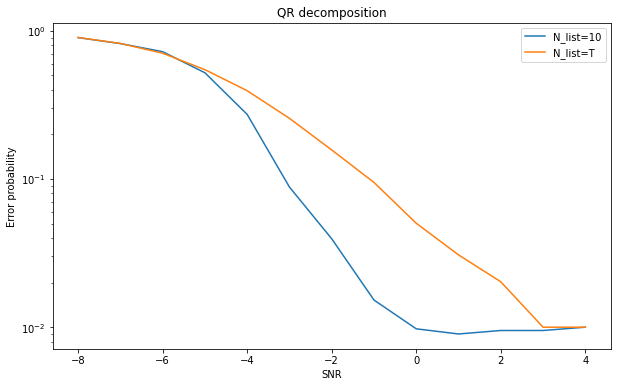

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="N_list=10")
ax.semilogy(SNR_array, np.reshape(Pr_error_T_qr, (1,np.product(Pr_error_T_qr.shape)))[0],label="N_list=T")

ax.set_title("QR decomposition")
ax.set_xlabel("SNR")
ax.set_ylabel("Error probability")
ax.legend()
plt.show()

## 4. Comparison for different $T$

In [ ]:
import itertools


### 4.1 QR

Here we used QR decomposition to compare decoding perfomance for different $T$

T = 3:

In [ ]:
num_tests = 2000
T = 3
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_qr_T3 = np.zeros((1,len(SNR_array)))

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]
        comb = np.array([list(itertools.combinations(cdw_idx, T))])

        dist_min = 100000      
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1] -A[:,comb[0][j,:]][:,2] )
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_qr_T3[0,i]=error/test
    print(Pr_error_qr_T3)

[[0.89416667 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.4705     0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.4705     0.34116667
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.4705     0.34116667
  0.23916667 0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62

T = 4:

In [ ]:
T = 4
Pr_error_qr_T4 = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]
        comb = np.array([list(itertools.combinations(cdw_idx, T))])

        dist_min = 100000      
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0] - A[:,comb[0][j,:]][:,1] -A[:,comb[0][j,:]][:,2] - A[:,comb[0][j,:]][:,3])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_qr_T4[0,i]=error/test
    print(Pr_error_qr_T4)

[[0.89025 0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]]
[[0.89025 0.842   0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]]
[[0.89025  0.842    0.777625 0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.       0.       0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.       0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.4495   0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.4495   0.39975
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.4495   0.39975
  0.37775 

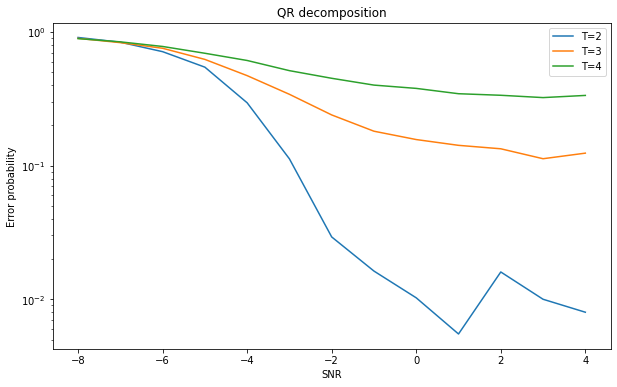

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="T=2")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr_T3, (1,np.product(Pr_error_qr_T3.shape)))[0],label="T=3")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr_T4, (1,np.product(Pr_error_qr_T4.shape)))[0],label="T=4")

ax.set_title("QR decomposition")
ax.set_xlabel("SNR")
ax.set_ylabel("Error probability")
ax.legend()
plt.show()

For larger T the error is rather high, but still decoder can recognize words 
from their noisy sum

### 4.2 NNLS

Here we used NNLS to compare decoding perfomance for different $T$

In [ ]:
T = 3

Pr_error_nnls_T3 = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]  
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1] - A[:,comb[0][j,:]][:,2])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T

        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_nnls_T3[0,i]=error/test

In [ ]:
T = 4

Pr_error_nnls_T4 = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]  
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1] - A[:,comb[0][j,:]][:,2] - A[:,comb[0][j,:]][:,3])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T

        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_nnls_T4[0,i]=error/test

NameError: ignored

In [ ]:
Pr_error_nnls_T4

array([[0.912625, 0.864125, 0.819625, 0.734   , 0.62225 , 0.495625,
        0.359125, 0.30225 , 0.268625, 0.23225 , 0.216125, 0.2215  ,
        0.207625]])

In [ ]:
Pr_error = [0.90775, 0.83775, 0.72175, 0.54, 0.2855 , 0.1105 , 0.046  , 0.0195 , 0.0175 , 0.014  , 0.013  , 0.0095 , 0.0065 ]

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  lib

In [ ]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super-minimal all 0.3.4-11 [5,810 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super all 0.3.4-11 [18.7 MB]
Fetched 24.5 MB in 3s (9,164 kB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 170743 files and directories currently installed.)
Preparing to unpack .../cm-super-minimal_0.3.4-11_all.deb ...
Unpacking cm-super-minimal (0.3.4-11) ...
Selecti

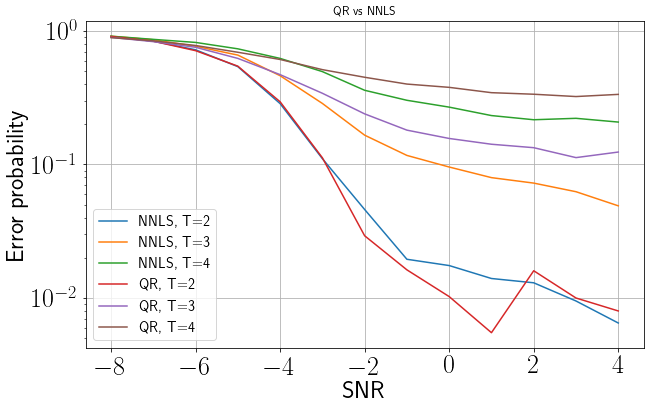

In [ ]:
import matplotlib.pyplot as plt
import latex

plt.figure(figsize=(10,6))
plt.rc("text", usetex=True)

plt.semilogy(SNR_array, Pr_error, label="NNLS, T=2")
plt.semilogy(SNR_array, np.reshape(Pr_error_nnls_T3, (1,np.product(Pr_error_nnls_T3.shape)))[0],label="NNLS, T=3")
plt.semilogy(SNR_array, np.reshape(Pr_error_nnls_T4, (1,np.product(Pr_error_nnls_T4.shape)))[0],label="NNLS, T=4")
plt.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="QR, T=2")
plt.semilogy(SNR_array, np.reshape(Pr_error_qr_T3, (1,np.product(Pr_error_qr_T3.shape)))[0],label="QR, T=3")
plt.semilogy(SNR_array, np.reshape(Pr_error_qr_T4, (1,np.product(Pr_error_qr_T4.shape)))[0],label="QR, T=4")


plt.title(r"QR vs NNLS")
plt.xlabel(r"SNR", fontsize=24)
plt.ylabel(r"Error probability", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=3,fontsize='x-large')
plt.grid()
plt.show()


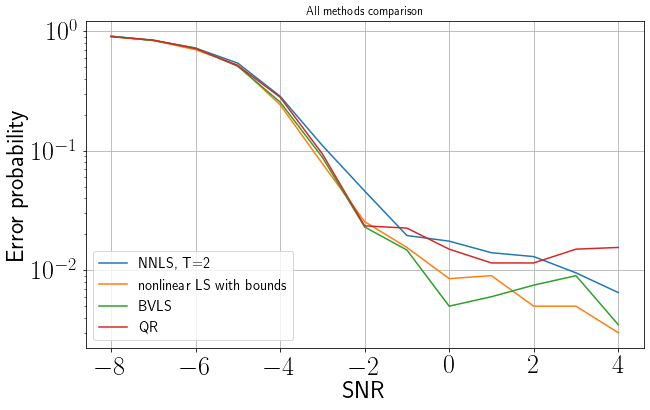

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.rc("text", usetex=True)

plt.semilogy(SNR_array, Pr_error, label="NNLS, T=2")
plt.semilogy(SNR_array, Pr_error_ls,label="nonlinear LS with bounds")
plt.semilogy(SNR_array, Pr_error_bv,label="BVLS")
plt.semilogy(SNR_array, np.reshape(Pr_error_qr, (1,np.product(Pr_error_qr.shape)))[0],label="QR")


plt.title(r"All methods comparison")
plt.xlabel(r"SNR", fontsize=24)
plt.ylabel(r"Error probability", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=3,fontsize='x-large')
plt.grid()
plt.show()

## 5. Time estimation

In [ ]:
%timeit Q, R = np.linalg.qr(A); np.linalg.pinv(R) @ np.conj(Q.T) @ y

100 loops, best of 3: 5.64 ms per loop


In [ ]:
%timeit nnls(A,y)

100 loops, best of 3: 3.28 ms per loop


In [ ]:
%timeit least_squares(leastsq, x0, bounds=(0,1))

1 loop, best of 3: 13 s per loop


In [ ]:
time_nnls = []
time_bvls = []
time_cs = []
time_qr = []
time_ls = []
for i in np.arange(len(sigma_array)):
    Mp=1024
    b = np.zeros((Mp,1))
    perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
    b[perm,0] = 1
    sigma = sigma_array[i]
    y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
    y = np.reshape(y, (1,np.product(y.shape)))[0]
    
    D = dct(A)
    x0=np.ones(1024)
    t1 = %timeit -o -q idct(lasso.fit(D, y).coef_, axis=0)
    time_cs.append(t1.average)
    t2 = %timeit -o -q lsq_linear(A, y, bounds=[0,1], method='bvls')
    time_bvls.append(t2.average)
    t3 = %timeit -o -q np.array([nnls(A,y)],dtype=object)[0,0]
    time_nnls.append(t3.average)
    t4 = %timeit -o -q Q, R = np.linalg.qr(A, mode="complete")
    t5 = %timeit -o -q np.linalg.pinv(R) @ np.conj(Q.T) @ y 
    time_qr.append(t4.average + t5.average)
    t6 = %timeit -o -q least_squares(leastsq,x0, bounds=(0,1))
    time_ls.append(t6.average)
    

In [ ]:
plt.figure(figsize=(10,6)) #plot working time for matrix A with shape (35, 1024)
plt.rc("text", usetex=True)

plt.semilogy(SNR_array, time_ls, label="LS with bounds")
# plt.semilogy(SNR_array, time_cs, label="Compressed sensing")
plt.semilogy(SNR_array, time_nnls, label="NNLS")
plt.semilogy(SNR_array, time_bvls, label="BVLS")
plt.semilogy(SNR_array, time_qr, label="QR")

plt.grid()
plt.title(r"For A with shape (35, 1024)", fontsize=24)
plt.ylabel(r"Average time", fontsize=24)
plt.xlabel(r"SNR", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=4,fontsize='large')
plt.savefig("Time_long.png")

In [ ]:
time_nnls = []
time_bvls = []
time_cs = []
time_qr = []
time_ls = []
for i in np.arange(len(sigma_array)):
    Mp = A_new.shape[1]
    A = A_new
    b = np.zeros((Mp,1))
    perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
    b[perm,0] = 1
    sigma = sigma_array[i]
    y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
    y = np.reshape(y, (1,np.product(y.shape)))[0]
    
    D = dct(A)
    x0=np.ones(60)
    t1 = %timeit -o -q idct(lasso.fit(D, y).coef_, axis=0)
    time_cs.append(t1.average)
    t2 = %timeit -o -q lsq_linear(A, y, bounds=[0,1], method='bvls')
    time_bvls.append(t2.average)
    t3 = %timeit -o -q np.array([nnls(A,y)],dtype=object)[0,0]
    time_nnls.append(t3.average)
    t4 = %timeit -o -q Q, R = np.linalg.qr(A, mode="complete")
    t5 = %timeit -o -q np.linalg.pinv(R) @ np.conj(Q.T) @ y 
    time_qr.append(t4.average + t5.average)
    t6 = %timeit -o -q least_squares(leastsq,x0, bounds=(0,1))
    time_ls.append(t6.average)

In [ ]:
plt.figure(figsize=(10,6)) #plot working time for matrix A with shape (35, 60)
plt.rc("text", usetex=True)

plt.semilogy(SNR_array, time_ls, label="LS with bounds")
plt.semilogy(SNR_array, time_qr, label="QR")
plt.semilogy(SNR_array, time_cs, label="Compressed sensing")
plt.semilogy(SNR_array, time_bvls, label="BVLS")
plt.semilogy(SNR_array, time_nnls, label="NNLS")

plt.grid()
plt.title(r"For A with shape (35, 60)", fontsize=24)
plt.ylabel(r"Average time", fontsize=24)
plt.xlabel(r"SNR", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=4,fontsize='large')
plt.savefig("Time_short.png")